# `causalml` - Meta-Learner Example Notebook
This notebook only contains regression examples.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor, XGBClassifier
import warnings

# from causalml.inference.meta import XGBTLearner, MLPTLearner
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from causalml.inference.meta import LRSRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# imports from package
import logging
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import statsmodels.api as sm
from copy import deepcopy

logger = logging.getLogger('causalml')
logging.basicConfig(level=logging.INFO)

%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Failed to import duecredit due to No module named 'duecredit'


# Single Treatment Case

### Generate synthetic data

In [3]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

treatment = np.array(['treatment_a' if val==1 else 'control' for val in treatment])

## S-Learner

### ATE

In [4]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=False, bootstrap_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6715
INFO:causalml:    RMSE (Treatment):     0.6761
INFO:causalml:   sMAPE   (Control):     0.6516
INFO:causalml:   sMAPE (Treatment):     0.3686
INFO:causalml:    Gini   (Control):     0.8223
INFO:causalml:    Gini (Treatment):     0.8173


In [5]:
ate_s

array([0.553453])

### ATE w/ Confidence Intervals

In [6]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
ate_s, ate_s_lb, ate_s_ub = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                                                   bootstrap_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6715
INFO:causalml:    RMSE (Treatment):     0.6761
INFO:causalml:   sMAPE   (Control):     0.6516
INFO:causalml:   sMAPE (Treatment):     0.3686
INFO:causalml:    Gini   (Control):     0.8223
INFO:causalml:    Gini (Treatment):     0.8173


In [7]:
np.vstack((ate_s_lb, ate_s, ate_s_ub))

array([[0.52589949],
       [0.553453  ],
       [0.58100652]])

### ATE w/ Boostrap Confidence Intervals

In [8]:
ate_s_b, ate_s_lb_b, ate_s_ub_b = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                                                         bootstrap_ci=True, n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6715
INFO:causalml:    RMSE (Treatment):     0.6761
INFO:causalml:   sMAPE   (Control):     0.6516
INFO:causalml:   sMAPE (Treatment):     0.3686
INFO:causalml:    Gini   (Control):     0.8223
INFO:causalml:    Gini (Treatment):     0.8173
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


In [9]:
np.vstack((ate_s_lb_b, ate_s_b, ate_s_ub_b))

array([[0.4853624 ],
       [0.553453  ],
       [0.62330767]])

### CATE

In [10]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6715
INFO:causalml:    RMSE (Treatment):     0.6761
INFO:causalml:   sMAPE   (Control):     0.6516
INFO:causalml:   sMAPE (Treatment):     0.3686
INFO:causalml:    Gini   (Control):     0.8223
INFO:causalml:    Gini (Treatment):     0.8173


In [11]:
cate_s

array([[ 0.19388527],
       [ 0.53801417],
       [ 0.58157051],
       ...,
       [ 0.81142545],
       [ 0.21532393],
       [-0.25809848]])

### CATE w/ Confidence Intervals

In [12]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
cate_s, cate_s_lb, cate_s_ub = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                               n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6715
INFO:causalml:    RMSE (Treatment):     0.6761
INFO:causalml:   sMAPE   (Control):     0.6516
INFO:causalml:   sMAPE (Treatment):     0.3686
INFO:causalml:    Gini   (Control):     0.8223
INFO:causalml:    Gini (Treatment):     0.8173
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


In [13]:
cate_s

array([[ 0.19388527],
       [ 0.53801417],
       [ 0.58157051],
       ...,
       [ 0.81142545],
       [ 0.21532393],
       [-0.25809848]])

In [14]:
cate_s_lb

array([[-0.17045946],
       [ 0.35809874],
       [-0.1705403 ],
       ...,
       [ 0.14650098],
       [-0.27509055],
       [-0.56130544]])

In [15]:
cate_s_ub

array([[1.16604015],
       [1.56744029],
       [0.89933195],
       ...,
       [1.11732626],
       [1.32394142],
       [0.87057412]])

## T-Learner

### ATE w/ Confidence Intervals

In [16]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
ate_t, ate_t_lb, ate_t_ub = learner_t.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.5123
INFO:causalml:   sMAPE   (Control):     0.5042
INFO:causalml:   sMAPE (Treatment):     0.2969
INFO:causalml:    Gini   (Control):     0.9290
INFO:causalml:    Gini (Treatment):     0.9106


In [17]:
np.vstack((ate_t_lb, ate_t, ate_t_ub))

array([[0.51587201],
       [0.54098956],
       [0.56610712]])

### ATE w/ Boostrap Confidence Intervals

In [18]:
ate_t_b, ate_t_lb_b, ate_t_ub_b = learner_t.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.5123
INFO:causalml:   sMAPE   (Control):     0.5042
INFO:causalml:   sMAPE (Treatment):     0.2969
INFO:causalml:    Gini   (Control):     0.9290
INFO:causalml:    Gini (Treatment):     0.9106
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [04:10<00:00,  2.51s/it]


In [19]:
np.vstack((ate_t_lb_b, ate_t_b, ate_t_ub_b))

array([[0.46532569],
       [0.54098956],
       [0.61520053]])

### CATE

In [20]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.5123
INFO:causalml:   sMAPE   (Control):     0.5042
INFO:causalml:   sMAPE (Treatment):     0.2969
INFO:causalml:    Gini   (Control):     0.9290
INFO:causalml:    Gini (Treatment):     0.9106


In [21]:
cate_t

array([[-0.7817564 ],
       [ 1.96460402],
       [-0.11471784],
       ...,
       [ 0.50215238],
       [ 1.94092751],
       [ 0.50172436]])

### CATE w/ Confidence Intervals

In [22]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t, cate_t_lb, cate_t_ub = learner_t.fit_predict(X=X, treatment=treatment, y=y, return_ci=True, n_bootstraps=100,
                                                    bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.5123
INFO:causalml:   sMAPE   (Control):     0.5042
INFO:causalml:   sMAPE (Treatment):     0.2969
INFO:causalml:    Gini   (Control):     0.9290
INFO:causalml:    Gini (Treatment):     0.9106
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [07:33<00:00,  4.53s/it]


In [23]:
cate_t

array([[-0.7817564 ],
       [ 1.96460402],
       [-0.11471784],
       ...,
       [ 0.50215238],
       [ 1.94092751],
       [ 0.50172436]])

In [24]:
cate_t_lb

array([[-1.3958913 ],
       [-0.86684363],
       [-1.10340049],
       ...,
       [-0.40302873],
       [-1.02907973],
       [-0.87140086]])

In [25]:
cate_t_ub

array([[1.34554911],
       [2.36166096],
       [1.39806437],
       ...,
       [1.45734572],
       [2.66094267],
       [2.05946385]])

## X-Learner

### ATE w/ Confidence Intervals

#### With Propensity Score Input

In [26]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
ate_x, ate_x_lb, ate_x_ub = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.5123
INFO:causalml:   sMAPE   (Control):     0.5042
INFO:causalml:   sMAPE (Treatment):     0.2969
INFO:causalml:    Gini   (Control):     0.9290
INFO:causalml:    Gini (Treatment):     0.9106


In [27]:
np.vstack((ate_x_lb, ate_x, ate_x_ub))

array([[0.47304206],
       [0.49512369],
       [0.51720531]])

#### Without Propensity Score input

In [28]:
ate_x_no_p, ate_x_lb_no_p, ate_x_ub_no_p = learner_x.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.5123
INFO:causalml:   sMAPE   (Control):     0.5042
INFO:causalml:   sMAPE (Treatment):     0.2969
INFO:causalml:    Gini   (Control):     0.9290
INFO:causalml:    Gini (Treatment):     0.9106


In [29]:
np.vstack((ate_x_lb_no_p, ate_x_no_p, ate_x_ub_no_p))

array([[0.47770923],
       [0.49976967],
       [0.52183012]])

In [30]:
learner_x.propensity_model

{'treatment_a': LogisticRegressionCV(Cs=array([1.00230524, 2.15608891, 4.63802765, 9.97700064]),
                      cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                      l1_ratios=array([0.001     , 0.33366667, 0.66633333, 0.999     ]),
                      penalty='elasticnet', random_state=42, solver='saga')}

### ATE w/ Boostrap Confidence Intervals

#### With Propensity Score Input

In [31]:
ate_x_b, ate_x_lb_b, ate_x_ub_b = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.5123
INFO:causalml:   sMAPE   (Control):     0.5042
INFO:causalml:   sMAPE (Treatment):     0.2969
INFO:causalml:    Gini   (Control):     0.9290
INFO:causalml:    Gini (Treatment):     0.9106
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [07:35<00:00,  4.55s/it]


In [32]:
np.vstack((ate_x_lb_b, ate_x_b, ate_x_ub_b))

array([[0.41452946],
       [0.49512369],
       [0.5586011 ]])

#### Without Propensity Score Input

In [33]:
ate_x_b_no_p, ate_x_lb_b_no_p, ate_x_ub_b_no_p = learner_x.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Generating propensity score


INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.5123
INFO:causalml:   sMAPE   (Control):     0.5042
INFO:causalml:   sMAPE (Treatment):     0.2969
INFO:causalml:    Gini   (Control):     0.9290
INFO:causalml:    Gini (Treatment):     0.9106
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [05:47<00:00,  3.48s/it]


In [34]:
np.vstack((ate_x_lb_b_no_p, ate_x_b_no_p, ate_x_ub_b_no_p))

array([[0.42577051],
       [0.49976967],
       [0.59197433]])

### CATE

#### With Propensity Score Input

In [35]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.5123
INFO:causalml:   sMAPE   (Control):     0.5042
INFO:causalml:   sMAPE (Treatment):     0.2969
INFO:causalml:    Gini   (Control):     0.9290
INFO:causalml:    Gini (Treatment):     0.9106


In [36]:
cate_x

array([[-0.47097521],
       [ 1.13250971],
       [ 0.07736126],
       ...,
       [ 0.37328167],
       [ 1.69502912],
       [ 0.10810449]])

#### Without Propensity Score Input

In [37]:
cate_x_no_p = learner_x.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score


INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.5123
INFO:causalml:   sMAPE   (Control):     0.5042
INFO:causalml:   sMAPE (Treatment):     0.2969
INFO:causalml:    Gini   (Control):     0.9290
INFO:causalml:    Gini (Treatment):     0.9106


In [38]:
cate_x_no_p

array([[-0.451564  ],
       [ 1.129093  ],
       [ 0.08056108],
       ...,
       [ 0.34153235],
       [ 1.61119016],
       [ 0.11391069]])

### CATE w/ Confidence Intervals

#### With Propensity Score Input

In [39]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x, cate_x_lb, cate_x_ub = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=3000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.5123
INFO:causalml:   sMAPE   (Control):     0.5042
INFO:causalml:   sMAPE (Treatment):     0.2969
INFO:causalml:    Gini   (Control):     0.9290
INFO:causalml:    Gini (Treatment):     0.9106
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [04:43<00:00,  2.83s/it]


In [40]:
cate_x

array([[-0.47097521],
       [ 1.13250971],
       [ 0.07736126],
       ...,
       [ 0.37328167],
       [ 1.69502912],
       [ 0.10810449]])

In [41]:
cate_x_lb

array([[-0.64204219],
       [-0.30093444],
       [-0.51922675],
       ...,
       [-0.06288861],
       [-0.60912464],
       [-0.75679027]])

In [42]:
cate_x_ub

array([[1.57674491],
       [1.68459269],
       [1.11518906],
       ...,
       [1.40088332],
       [1.80225242],
       [1.54807597]])

#### Without Propensity Score Input

In [43]:
cate_x_no_p, cate_x_lb_no_p, cate_x_ub_no_p = learner_x.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=3000)

INFO:causalml:Generating propensity score


INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.5123
INFO:causalml:   sMAPE   (Control):     0.5042
INFO:causalml:   sMAPE (Treatment):     0.2969
INFO:causalml:    Gini   (Control):     0.9290
INFO:causalml:    Gini (Treatment):     0.9106
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [04:52<00:00,  2.92s/it]


In [44]:
cate_x_no_p

array([[-0.451564  ],
       [ 1.129093  ],
       [ 0.08056108],
       ...,
       [ 0.34153235],
       [ 1.61119016],
       [ 0.11391069]])

In [45]:
cate_x_lb_no_p

array([[-1.13864854],
       [-0.42270605],
       [-0.39454174],
       ...,
       [-0.15806432],
       [-0.69719693],
       [-0.66722489]])

In [46]:
cate_x_ub_no_p

array([[1.61421556],
       [1.69973035],
       [1.1341171 ],
       ...,
       [1.16627774],
       [1.86392105],
       [1.02637874]])

## R-Learner

### ATE w/ Confidence Intervals

#### With Propensity Score Input

In [47]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
ate_r, ate_r_lb, ate_r_ub = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss


In [48]:
np.vstack((ate_r_lb, ate_r, ate_r_ub))

array([[0.49650136],
       [0.4969706 ],
       [0.49743984]])

#### Without Propensity Score Input

In [49]:
ate_r_no_p, ate_r_lb_no_p, ate_r_ub_no_p = learner_r.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss


In [50]:
np.vstack((ate_r_lb_no_p, ate_r_no_p, ate_r_ub_no_p))

array([[0.4638673 ],
       [0.46433703],
       [0.46480676]])

In [51]:
learner_r.propensity_model

{'treatment_a': LogisticRegressionCV(Cs=array([1.00230524, 2.15608891, 4.63802765, 9.97700064]),
                      cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                      l1_ratios=array([0.001     , 0.33366667, 0.66633333, 0.999     ]),
                      penalty='elasticnet', random_state=42, solver='saga')}

### ATE w/ Boostrap Confidence Intervals

#### With Propensity Score Input

In [52]:
ate_r_b, ate_r_lb_b, ate_r_ub_b = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:Bootstrap Confidence Intervals for ATE
  0%|          | 0/100 [00:00<?, ?it/s]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
  1%|          | 1/100 [00:05<08:31,  5.16s/it]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
  2%|▏         | 2/100 [00:10<08:58,  5.50s/it]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
  3%|▎         | 3/100 [00:14<07:16,  4.50s/it]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
  4%|▍         | 4/100 [00:20<08:09,  5.10s/it]INFO:causalml:generating out-of-fold CV 

In [53]:
np.vstack((ate_r_lb_b, ate_r_b, ate_r_ub_b))

array([[0.35126952],
       [0.49067895],
       [0.52199466]])

#### Without Propensity Score Input

In [54]:
ate_r_b_no_p, ate_r_lb_b_no_p, ate_r_ub_b_no_p = learner_r.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:Bootstrap Confidence Intervals for ATE
  0%|          | 0/100 [00:00<?, ?it/s]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
  1%|          | 1/100 [00:01<03:13,  1.95s/it]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
  2%|▏         | 2/100 [00:04<03:23,  2.08s/it]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
  3%|▎         | 3/100 [00:06<03:33,  2.20s/it]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss


In [55]:
np.vstack((ate_r_lb_b_no_p, ate_r_b_no_p, ate_r_ub_b_no_p))

array([[0.34642705],
       [0.47147059],
       [0.51159666]])

### CATE

#### With Propensity Score Input

In [56]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss


In [57]:
cate_r

array([[-0.14502913],
       [ 2.20173955],
       [ 0.53709263],
       ...,
       [ 0.25299761],
       [ 3.23873138],
       [ 1.06599319]])

#### Without Propensity Score Input

In [58]:
cate_r_no_p = learner_r.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss


In [59]:
cate_r_no_p

array([[-1.75479043],
       [ 1.94762349],
       [ 0.29624853],
       ...,
       [-0.06071158],
       [ 4.19073296],
       [ 1.59144044]])

### CATE w/ Confidence Intervals

#### With Propensity Score Input

In [60]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r, cate_r_lb, cate_r_ub = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:Bootstrap Confidence Intervals
  0%|          | 0/100 [00:00<?, ?it/s]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
  1%|          | 1/100 [00:00<01:13,  1.35it/s]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
  2%|▏         | 2/100 [00:01<01:05,  1.49it/s]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
  3%|▎         | 3/100 [00:01<01:03,  1.54it/s]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
  4%|▍         | 4/100 [00:02<01:02,  1.53it/s]INFO:causalml:generating out-of-fold CV outcome 

In [61]:
cate_r

array([[-1.22698724],
       [ 2.71953249],
       [-0.13756624],
       ...,
       [ 0.5618239 ],
       [ 2.58041811],
       [ 0.81730705]])

In [62]:
cate_r_lb

array([[-3.43615302],
       [-2.147553  ],
       [-2.81021295],
       ...,
       [-2.11117566],
       [-2.01934255],
       [-1.76639521]])

In [63]:
cate_r_ub

array([[3.68913299],
       [4.59937366],
       [2.79808745],
       ...,
       [3.04937114],
       [4.2900426 ],
       [3.79833399]])

#### Without Propensity Score Input

In [64]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r_no_p, cate_r_lb_no_p, cate_r_ub_no_p = learner_r.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:Generating propensity score


INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:Bootstrap Confidence Intervals
  0%|          | 0/100 [00:00<?, ?it/s]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
  1%|          | 1/100 [00:01<02:04,  1.26s/it]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
  2%|▏         | 2/100 [00:02<01:57,  1.20s/it]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
  3%|▎         | 3/100 [00:03<01:46,  1.09s/it]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
  4%|▍         | 4/100 [00:04<01:37,  1.01s/it]INF

In [65]:
cate_r_no_p

array([[-0.52747166],
       [ 1.25635076],
       [-0.25144646],
       ...,
       [ 0.49343434],
       [ 2.96903896],
       [ 1.06650448]])

In [66]:
cate_r_lb_no_p

array([[-2.44348627],
       [-3.01379174],
       [-3.16465318],
       ...,
       [-1.69092604],
       [-2.00299096],
       [-2.8464227 ]])

In [67]:
cate_r_ub_no_p

array([[3.35444879],
       [4.58988643],
       [3.41727435],
       ...,
       [3.04357766],
       [4.56808878],
       [2.50545568]])

# Visualize

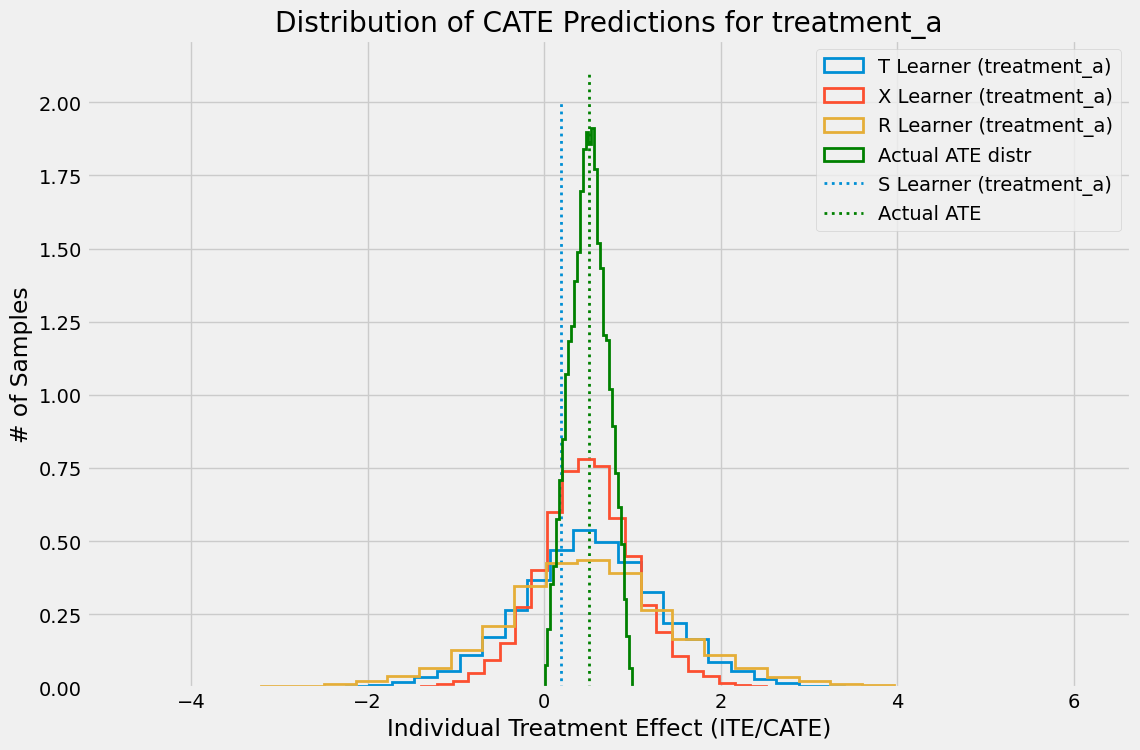

In [68]:
groups = learner_r._classes

alpha = 1
linewidth = 2
bins = 30
for group,idx in sorted(groups.items(), key=lambda x: x[1]):
    plt.figure(figsize=(12,8))
    plt.hist(cate_t[:,idx], alpha=alpha, bins=bins, label='T Learner ({})'.format(group),
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(cate_x[:,idx], alpha=alpha, bins=bins, label='X Learner ({})'.format(group),
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(cate_r[:,idx], alpha=alpha, bins=bins, label='R Learner ({})'.format(group),
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(tau, alpha=alpha, bins=bins, label='Actual ATE distr',
             histtype='step', linewidth=linewidth, color='green', density=True)
    plt.vlines(cate_s[0,idx], 0, plt.axes().get_ylim()[1], label='S Learner ({})'.format(group),
               linestyles='dotted', linewidth=linewidth)
    plt.vlines(tau.mean(), 0, plt.axes().get_ylim()[1], label='Actual ATE',
               linestyles='dotted', linewidth=linewidth, color='green')
    
    plt.title('Distribution of CATE Predictions for {}'.format(group))
    plt.xlabel('Individual Treatment Effect (ITE/CATE)')
    plt.ylabel('# of Samples')
    _=plt.legend()

---
# Multiple Treatment Case

### Generate synthetic data
Note: we randomize the assignment of treatment flag AFTER the synthetic data generation process, so it doesn't make sense to measure accuracy metrics here. Next steps would be to include multi-treatment in the DGP itself.

In [69]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

treatment = np.array([('treatment_a' if np.random.random() > 0.2 else 'treatment_b') 
                      if val==1 else 'control' for val in treatment])

e = {group: e for group in np.unique(treatment)}

In [70]:
pd.Series(treatment).value_counts()

control        4901
treatment_a    4094
treatment_b    1005
dtype: int64

## S-Learner

### ATE

In [71]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=False, bootstrap_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6428
INFO:causalml:    RMSE (Treatment):     0.6576
INFO:causalml:   sMAPE   (Control):     0.6389
INFO:causalml:   sMAPE (Treatment):     0.3529
INFO:causalml:    Gini   (Control):     0.8336
INFO:causalml:    Gini (Treatment):     0.8341
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5434
INFO:causalml:    RMSE (Treatment):     0.4928
INFO:causalml:   sMAPE   (Control):     0.5670
INFO:causalml:   sMAPE (Treatment):     0.2852
INFO:causalml:    Gini   (Control):     0.8941
INFO:causalml:    Gini (Treatment):     0.9046


In [72]:
ate_s

array([0.56130834, 0.48720214])

In [73]:
learner_s._classes

{'treatment_a': 0, 'treatment_b': 1}

### ATE w/ Confidence Intervals

In [74]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
ate_s, ate_s_lb, ate_s_ub = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                                                   bootstrap_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6428
INFO:causalml:    RMSE (Treatment):     0.6576
INFO:causalml:   sMAPE   (Control):     0.6389
INFO:causalml:   sMAPE (Treatment):     0.3529
INFO:causalml:    Gini   (Control):     0.8336
INFO:causalml:    Gini (Treatment):     0.8341
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5434
INFO:causalml:    RMSE (Treatment):     0.4928
INFO:causalml:   sMAPE   (Control):     0.5670
INFO:causalml:   sMAPE (Treatment):     0.2852
INFO:causalml:    Gini   (Control):     0.8941
INFO:causalml:    Gini (Treatment):     0.9046


In [75]:
np.vstack((ate_s_lb, ate_s, ate_s_ub))

array([[0.53337063, 0.45148332],
       [0.56130834, 0.48720214],
       [0.58924604, 0.52292097]])

### ATE w/ Boostrap Confidence Intervals

In [76]:
ate_s_b, ate_s_lb_b, ate_s_ub_b = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                                                         bootstrap_ci=True, n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6428
INFO:causalml:    RMSE (Treatment):     0.6576
INFO:causalml:   sMAPE   (Control):     0.6389
INFO:causalml:   sMAPE (Treatment):     0.3529
INFO:causalml:    Gini   (Control):     0.8336
INFO:causalml:    Gini (Treatment):     0.8341
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5434
INFO:causalml:    RMSE (Treatment):     0.4928
INFO:causalml:   sMAPE   (Control):     0.5670
INFO:causalml:   sMAPE (Treatment):     0.2852
INFO:causalml:    Gini   (Control):     0.8941
INFO:causalml:    Gini (Treatment):     0.9046
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [02:18<00:00,  1.38s/it]


In [77]:
np.vstack((ate_s_lb_b, ate_s_b, ate_s_ub_b))

array([[0.45649675, 0.45649675],
       [0.56130834, 0.48720214],
       [0.59095697, 0.59095697]])

### CATE

In [78]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6428
INFO:causalml:    RMSE (Treatment):     0.6576
INFO:causalml:   sMAPE   (Control):     0.6389
INFO:causalml:   sMAPE (Treatment):     0.3529
INFO:causalml:    Gini   (Control):     0.8336
INFO:causalml:    Gini (Treatment):     0.8341
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5434
INFO:causalml:    RMSE (Treatment):     0.4928
INFO:causalml:   sMAPE   (Control):     0.5670
INFO:causalml:   sMAPE (Treatment):     0.2852
INFO:causalml:    Gini   (Control):     0.8941
INFO:causalml:    Gini (Treatment):     0.9046


In [79]:
cate_s

array([[ 0.50269127,  0.28148568],
       [ 0.49630618, -0.272879  ],
       [ 0.31074429, -0.22502005],
       ...,
       [-0.23943236,  0.17926455],
       [ 0.04366732,  0.39293075],
       [ 0.48549354, -0.19117212]])

### CATE w/ Confidence Intervals

In [80]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
cate_s, cate_s_lb, cate_s_ub = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                               n_bootstraps=100, bootstrap_size=3000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6428
INFO:causalml:    RMSE (Treatment):     0.6576
INFO:causalml:   sMAPE   (Control):     0.6389
INFO:causalml:   sMAPE (Treatment):     0.3529
INFO:causalml:    Gini   (Control):     0.8336
INFO:causalml:    Gini (Treatment):     0.8341
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5434
INFO:causalml:    RMSE (Treatment):     0.4928
INFO:causalml:   sMAPE   (Control):     0.5670
INFO:causalml:   sMAPE (Treatment):     0.2852
INFO:causalml:    Gini   (Control):     0.8941
INFO:causalml:    Gini (Treatment):     0.9046
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [02:17<00:00,  1.38s/it]


In [81]:
cate_s

array([[ 0.50269127,  0.28148568],
       [ 0.49630618, -0.272879  ],
       [ 0.31074429, -0.22502005],
       ...,
       [-0.23943236,  0.17926455],
       [ 0.04366732,  0.39293075],
       [ 0.48549354, -0.19117212]])

In [82]:
cate_s_lb

array([[ 0.29459754,  0.16337148],
       [-0.14487143, -0.24886316],
       [-0.25559233, -0.50857609],
       ...,
       [-0.69400408, -0.76724518],
       [-0.40098217, -0.31653938],
       [-0.22512058, -0.38316111]])

In [83]:
cate_s_ub

array([[1.19039717, 1.44045162],
       [1.50682622, 1.14070666],
       [1.31162786, 1.3884688 ],
       ...,
       [0.82887924, 1.00939197],
       [1.24055386, 1.49877841],
       [1.0960682 , 1.26828566]])

## T-Learner

### ATE w/ Confidence Intervals

In [84]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
ate_t, ate_t_lb, ate_t_ub = learner_t.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.4666
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.2684
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9294
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.0762
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.0668
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9984


In [85]:
np.vstack((ate_t_lb, ate_t, ate_t_ub))

array([[0.53529178, 0.42444792],
       [0.56116837, 0.45119056],
       [0.58704496, 0.4779332 ]])

### ATE w/ Boostrap Confidence Intervals

In [86]:
ate_t_b, ate_t_lb_b, ate_t_ub_b = learner_t.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.4666
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.2684
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9294
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.0762
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.0668
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9984
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


In [87]:
np.vstack((ate_t_lb_b, ate_t_b, ate_t_ub_b))

array([[0.47689478, 0.47689478],
       [0.56116837, 0.45119056],
       [0.6455047 , 0.6455047 ]])

### CATE

In [88]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.4666
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.2684
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9294
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.0762
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.0668
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9984


In [89]:
cate_t

array([[ 0.8710196 ,  1.05108261],
       [ 0.78783238,  0.47293699],
       [-0.60484207, -1.58841085],
       ...,
       [ 0.20689231,  0.23559123],
       [-0.43815756,  0.02434623],
       [ 0.49013877,  0.07333577]])

### CATE w/ Confidence Intervals

In [90]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t, cate_t_lb, cate_t_ub = learner_t.fit_predict(X=X, treatment=treatment, y=y, return_ci=True, n_bootstraps=100,
                                                    bootstrap_size=3000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.4666
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.2684
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9294
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.0762
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.0668
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9984
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


In [91]:
cate_t

array([[ 0.8710196 ,  1.05108261],
       [ 0.78783238,  0.47293699],
       [-0.60484207, -1.58841085],
       ...,
       [ 0.20689231,  0.23559123],
       [-0.43815756,  0.02434623],
       [ 0.49013877,  0.07333577]])

In [92]:
cate_t_lb

array([[-0.20293337, -0.38047023],
       [-0.54715382, -0.71124427],
       [-1.0054347 , -1.45525059],
       ...,
       [-1.06487394, -1.13718721],
       [-1.15750725, -0.84369106],
       [-0.80103379, -1.01834091]])

In [93]:
cate_t_ub

array([[1.7434435 , 2.01678751],
       [1.88592992, 1.7763956 ],
       [2.08014303, 1.7153545 ],
       ...,
       [1.50827478, 1.56319493],
       [1.21899557, 1.90980104],
       [1.67495072, 1.50348173]])

## X-Learner

### ATE w/ Confidence Intervals

#### With Propensity Score Input

In [94]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
ate_x, ate_x_lb, ate_x_ub = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.4666
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.2684
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9294
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.0762
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.0668
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9984


In [95]:
np.vstack((ate_x_lb, ate_x, ate_x_ub))

array([[0.52135082, 0.40763892],
       [0.54410916, 0.4282452 ],
       [0.56686751, 0.44885148]])

#### Without Propensity Score Input

In [96]:
ate_x_no_p, ate_x_lb_no_p, ate_x_ub_no_p = learner_x.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.4666
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.2684
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9294
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.0762
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.0668
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9984


In [97]:
np.vstack((ate_x_lb_no_p, ate_x_no_p, ate_x_ub_no_p))

array([[0.52745731, 0.44514185],
       [0.5502046 , 0.46688824],
       [0.5729519 , 0.48863463]])

### ATE w/ Boostrap Confidence Intervals

#### With Propensity Score Input

In [98]:
ate_x_b, ate_x_lb_b, ate_x_ub_b = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.4666
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.2684
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9294
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.0762
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.0668
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9984
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [03:37<00:00,  2.18s/it]


In [99]:
np.vstack((ate_x_lb_b, ate_x_b, ate_x_ub_b))

array([[0.43867581, 0.43867581],
       [0.54410916, 0.4282452 ],
       [0.59360317, 0.59360317]])

#### Without Propensity Score Input

In [100]:
ate_x_b_no_p, ate_x_lb_b_no_p, ate_x_ub_b_no_p = learner_x.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.4666
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.2684
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9294
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.0762
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.0668
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9984
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [04:01<00:00,  2.41s/it]


In [101]:
np.vstack((ate_x_lb_b_no_p, ate_x_b_no_p, ate_x_ub_b_no_p))

array([[0.44339043, 0.44339043],
       [0.5502046 , 0.46688824],
       [0.6086471 , 0.6086471 ]])

### CATE

#### With Propensity Score Input

In [102]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.4666
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.2684
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9294
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.0762
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.0668
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9984


In [103]:
cate_x

array([[ 0.92429681,  1.16918001],
       [ 0.24184712,  0.13899262],
       [ 0.40760215, -0.39269372],
       ...,
       [-0.11447318,  0.79922857],
       [-0.03428511,  0.74230705],
       [ 0.78902056,  0.14734143]])

#### Without Propensity Score Input

In [104]:
cate_x_no_p = learner_x.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.4666
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.2684
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9294
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.0762
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.0668
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9984


In [105]:
cate_x_no_p

array([[ 0.8849927 ,  1.41021664],
       [ 0.2106727 , -0.05873892],
       [ 0.49473852, -1.34930939],
       ...,
       [-0.11901176,  0.84048279],
       [-0.03282562,  0.8382304 ],
       [ 0.8505627 ,  0.11556134]])

### CATE w/ Confidence Intervals

#### With Propensity Score Input

In [106]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x, cate_x_lb, cate_x_ub = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.4666
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.2684
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9294
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.0762
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.0668
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9984
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


In [107]:
learner_x._classes

{'treatment_a': 0, 'treatment_b': 1}

In [108]:
cate_x

array([[ 0.92429681,  1.16918001],
       [ 0.24184712,  0.13899262],
       [ 0.40760215, -0.39269372],
       ...,
       [-0.11447318,  0.79922857],
       [-0.03428511,  0.74230705],
       [ 0.78902056,  0.14734143]])

In [109]:
cate_x_lb

array([[-0.18673712, -0.32953741],
       [-0.43782282, -0.72505721],
       [-1.00106195, -0.76799021],
       ...,
       [-1.20705917, -1.36107737],
       [-0.34698897, -0.34203255],
       [-0.63917928, -0.99268518]])

In [110]:
cate_x_ub

array([[1.65268745, 1.60491722],
       [1.86838738, 1.72666198],
       [1.43481716, 1.56935688],
       ...,
       [1.1893953 , 1.48822278],
       [1.33727868, 1.76713081],
       [1.52999187, 1.46798457]])

#### Without Propensity Score Input

In [111]:
cate_x_no_p, cate_x_lb_no_p, cate_x_ub_no_p = learner_x.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.4666
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.2684
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9294
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5037
INFO:causalml:    RMSE (Treatment):     0.0762
INFO:causalml:   sMAPE   (Control):     0.5466
INFO:causalml:   sMAPE (Treatment):     0.0668
INFO:causalml:    Gini   (Control):     0.9109
INFO:causalml:    Gini (Treatment):     0.9984
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


In [112]:
learner_x._classes

{'treatment_a': 0, 'treatment_b': 1}

In [113]:
cate_x_no_p

array([[ 0.8849927 ,  1.41021664],
       [ 0.2106727 , -0.05873892],
       [ 0.49473852, -1.34930939],
       ...,
       [-0.11901176,  0.84048279],
       [-0.03282562,  0.8382304 ],
       [ 0.8505627 ,  0.11556134]])

In [114]:
cate_x_lb_no_p

array([[-0.12018011, -0.11233023],
       [-0.77945061, -0.73538064],
       [-0.47392431, -0.70754141],
       ...,
       [-0.85895971, -0.93429837],
       [-0.414727  , -0.74518244],
       [-0.72130947, -0.98566436]])

In [115]:
cate_x_ub_no_p

array([[1.61259223, 1.97972922],
       [1.53680045, 1.59421014],
       [1.62171704, 2.11348523],
       ...,
       [1.42519529, 1.43087704],
       [1.41314802, 1.76657001],
       [1.32913125, 1.48764182]])

## R-Learner

### ATE w/ Confidence Intervals

#### With Propensity Score Input

In [116]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
ate_r, ate_r_lb, ate_r_ub = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:generating out-of-fold CV outcome estimates


INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss


In [117]:
np.vstack((ate_r_lb, ate_r, ate_r_ub))

array([[0.5124421 , 0.45701203],
       [0.51291047, 0.4577127 ],
       [0.51337884, 0.45841336]])

#### Without Propensity Score Input

In [118]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
ate_r_no_p, ate_r_lb_no_p, ate_r_ub_no_p = learner_r.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss


In [119]:
np.vstack((ate_r_lb_no_p, ate_r_no_p, ate_r_ub_no_p))

array([[0.44162624, 0.57781926],
       [0.44209413, 0.57851711],
       [0.44256202, 0.57921496]])

In [120]:
learner_r.propensity_model

{'treatment_a': LogisticRegressionCV(Cs=array([1.00230524, 2.15608891, 4.63802765, 9.97700064]),
                      cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                      l1_ratios=array([0.001     , 0.33366667, 0.66633333, 0.999     ]),
                      penalty='elasticnet', random_state=42, solver='saga'),
 'treatment_b': LogisticRegressionCV(Cs=array([1.00230524, 2.15608891, 4.63802765, 9.97700064]),
                      cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                      l1_ratios=array([0.001     , 0.33366667, 0.66633333, 0.999     ]),
                      penalty='elasticnet', random_state=42, solver='saga')}

### ATE w/ Boostrap Confidence Intervals

#### With Propensity Score Input

In [121]:
ate_r_b, ate_r_lb_b, ate_r_ub_b = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
INFO:causalml:Bootstrap Confidence Intervals for ATE
  0%|          | 0/100 [00:00<?, ?it/s]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
  1%|          | 1/100 [00:01<02:16,  1.38s/it]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
  2%|▏         | 2/100 [00:02<02:15,  1.39s/it]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment

In [122]:
np.vstack((ate_r_lb_b, ate_r_b, ate_r_ub_b))

array([[0.35617504, 0.35617504],
       [0.51503364, 0.48987875],
       [0.53482837, 0.53482837]])

#### Without Propensity Score Input

In [123]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
ate_r_b_no_p, ate_r_lb_b_no_p, ate_r_ub_b_no_p = learner_r.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Generating propensity score


INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
INFO:causalml:Bootstrap Confidence Intervals for ATE
  0%|          | 0/100 [00:00<?, ?it/s]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
  1%|          | 1/100 [00:01<02:32,  1.55s/it]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
  2%|▏         | 2/100 [00:03<02:39,  1.63s/it]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training t

In [124]:
np.vstack((ate_r_lb_b_no_p, ate_r_b_no_p, ate_r_ub_b_no_p))

array([[0.43911503, 0.43911503],
       [0.44762754, 0.53157838],
       [0.65616755, 0.65616755]])

### CATE

#### With Propensity Score Input

In [125]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss


In [126]:
cate_r

array([[ 0.43111724,  2.04472971],
       [ 0.51401317,  1.77704823],
       [-0.57836366, -0.32937753],
       ...,
       [ 0.36808404,  0.00659637],
       [-0.10337357,  0.36800528],
       [ 0.55256903, -0.31787136]])

#### Without Propensity Score Input

In [127]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r_no_p = learner_r.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss


In [128]:
cate_r_no_p

array([[ 0.10300241,  0.61422968],
       [ 0.44722587,  0.49971887],
       [-1.36894822, -1.58307838],
       ...,
       [ 0.05531795,  0.43949288],
       [-0.3850221 ,  0.27994096],
       [ 1.51286435,  0.0686876 ]])

### CATE w/ Confidence Intervals

#### With Propensity Score Input

In [129]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r, cate_r_lb, cate_r_ub = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:generating out-of-fold CV outcome estimates


INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
INFO:causalml:Bootstrap Confidence Intervals
  0%|          | 0/100 [00:00<?, ?it/s]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
  1%|          | 1/100 [00:00<01:03,  1.55it/s]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
  2%|▏         | 2/100 [00:01<00:57,  1.72it/s]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
  3%|▎         | 3/100 [

In [130]:
cate_r

array([[ 0.69759923,  1.98660493],
       [ 0.86930412,  0.85287362],
       [-1.41234696, -0.41389269],
       ...,
       [ 0.2003686 ,  0.23568387],
       [ 0.27063122,  1.12373257],
       [ 0.22076607, -1.01778758]])

In [131]:
cate_r_lb

array([[-1.63802417, -1.62833956],
       [-1.9073961 , -2.53283474],
       [-2.27743037, -4.31789323],
       ...,
       [-4.48231773, -4.80733117],
       [-2.87203103, -1.9526327 ],
       [-2.37416928, -2.48644573]])

In [132]:
cate_r_ub

array([[3.81091431, 2.62589681],
       [3.07949586, 4.02612439],
       [4.26488676, 2.99495066],
       ...,
       [3.11108944, 4.17014825],
       [2.3913163 , 3.17441444],
       [2.98504456, 3.54218569]])

#### Without Propensity Score Input

In [133]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r_no_p, cate_r_lb_no_p, cate_r_ub_no_p = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
INFO:causalml:Bootstrap Confidence Intervals
  0%|          | 0/100 [00:00<?, ?it/s]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
  1%|          | 1/100 [00:00<00:46,  2.14it/s]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
  2%|▏         | 2/100 [00:00<00:48,  2.03it/s]INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect 

In [134]:
cate_r_no_p

array([[ 1.18406844,  1.40075612],
       [ 0.23563105,  0.21784915],
       [-1.37732232, -2.0412221 ],
       ...,
       [ 0.76216257, -1.62414813],
       [ 0.31919017,  0.40114835],
       [ 1.19208908, -0.09754898]])

In [135]:
cate_r_lb_no_p

array([[-1.21251562, -1.71429718],
       [-2.29351541, -2.04257072],
       [-2.21761301, -3.88994483],
       ...,
       [-3.44795143, -4.77241526],
       [-1.69889847, -2.1237779 ],
       [-1.98958459, -2.4258362 ]])

In [136]:
cate_r_ub_no_p

array([[2.87720219, 2.95348138],
       [3.89363839, 3.60064299],
       [5.09341813, 2.71669   ],
       ...,
       [2.64695951, 4.11184847],
       [2.61033067, 2.96829662],
       [2.94967496, 3.30866792]])